In [1]:
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

# NST

- input: content image, style image
- output: generate image like (content + style) from noise image by using gradient descent

## References

- https://keras.io/examples/generative/neural_style_transfer/

# Load VGG-19 Model

In [2]:
# neural style transfer output

content_layers = ['block4_conv2']
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1',
]

In [3]:
def load_vgg():
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    # vgg.trainable = False
    
    # extracted feature
    layers = content_layers + style_layers
    outputs_dict = dict([(layer, vgg.get_layer(layer).output) for layer in layers])
    
    # model for nst
    feature_extractor = tf.keras.Model(inputs=vgg.input, outputs=outputs_dict)
    
    return feature_extractor

# Image Preprocessing

In [4]:
def preprocess_image(image_path, image_size=(500, 500)):
    """
        return: tensor type array. shape (1, height, width, channel).
    """
    
    
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=image_size 
    )
    
    # image to numpy array shape (h, w, c)
    img = tf.keras.preprocessing.image.img_to_array(img)
    
    # to shape (1, h, w, c)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    
    return tf.convert_to_tensor(img)

In [5]:
def deprocess_image(tensor_img):
    img = np.array(tensor_img.numpy()[0], dtype=np.float64)
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")

    return img

# Generated Image Tensor

In [6]:
def load_random_noise_tensor(img_tensor):
    random_noise = np.array(np.random.randint(0, 255, img_tensor.shape))
    gen_tensor = tf.Variable(random_noise, dtype=tf.float32)
    return gen_tensor

# Compute Loss

## Content loss

In [7]:
def compute_content_loss(content_feature, gen_feature, loss_weight=2e-8):
    return loss_weight*tf.reduce_sum(tf.square(content_feature - gen_feature))

## Style loss

In [8]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

In [9]:
def style_loss(style_feature, gen_feature, img_size, loss_weight=1e-6):
    S = gram_matrix(style_feature)
    G = gram_matrix(gen_feature)
    channels = 3
    size = img_size[0] * img_size[1]
    return loss_weight*tf.reduce_sum(tf.square(S - G))/(4.0*(channels**2)*(size**2))

## Total Loss

In [10]:
def compute_total_loss(content_tensor, style_tensor, gen_tensor, content_layers, style_layers, img_size, a=0.8, b=0.2):
    input_tensor = tf.concat(
        [content_tensor, style_tensor, gen_tensor], axis=0
    )
    features = model(input_tensor)
    
    content_features = features[content_layers[0]]
    
    loss = tf.zeros(shape=())
    
    content_loss = compute_content_loss(content_features[0], content_features[2])
    loss += a*content_loss
    
    total_style_loss = tf.zeros(shape=())
    for layer in style_layers:
        layer_feature = features[layer]
        style_feature = layer_feature[1]
        gen_style_feature = layer_feature[2]
        layer_style_loss = style_loss(style_feature, gen_style_feature, img_size)
        loss += (b/len(style_layers)) * layer_style_loss
        total_style_loss += (b/len(style_layers)) * layer_style_loss
        
    return loss, content_loss, total_style_loss

# Gradient

In [11]:
@tf.function
def compute_loss_and_grads(content_image_tensor, style_image_tensor, gen_image_tensor, content_layers, style_layers, img_size, content_w, style_w):
    with tf.GradientTape() as tape:
        loss, content_loss, total_style_loss = compute_total_loss(content_image_tensor, style_image_tensor, gen_image_tensor, 
                                                                  content_layers, style_layers, img_size, content_w, style_w)
    grads = tape.gradient(loss, gen_image_tensor)
    return loss, content_loss, total_style_loss, grads

# Training Function

In [12]:
def training_loop(content_tensor, style_tensor, gen_tensor, content_layers, style_layers, img_size, optimizer, content_w=0.9, style_w=0.1, max_iterations=10000):
    for i in range(1, max_iterations+1):
        if (i % 500 == 0) or (i == 1) or (i == max_iterations):
            loss, content_loss, total_style_loss, grads = compute_loss_and_grads(content_tensor, style_tensor, gen_tensor, 
                                                                                 content_layers, style_layers, img_size, content_w, style_w)
            optimizer.apply_gradients([(grads, gen_tensor)])
            print(f"iteration {i:8}, loss {loss:.2f}, content loss {content_loss:.2f}, style loss {total_style_loss:.2f}")
            
        # show image
        if (i % 2000 == 0) or (i == 1) or (i == max_iterations):
            fig = plt.figure(figsize=(5, 5))
            plt.title(f"iteration {i}")
            plt.imshow(deprocess_image(gen_tensor))
            plt.show()
        
        # save image
        if (i % 1000 == 0) or (i == 1) or (i == max_iterations):
            save_img_arr = deprocess_image(gen_tensor)
            tf.keras.preprocessing.image.save_img(f"./nst_output_img/{i}.jpg", save_img_arr)
    
    fig = plt.figure(figsize=(5, 5))
    plt.title("final result")
    plt.imshow(deprocess_image(gen_tensor))
    plt.show()

# ---
# Train Model
# ---

## Configuration

In [13]:
# image
content_img_path = "./img/bacc.jpg"
style_image_path = "./img/style_picasso.jpg"
resize_scale = 2.5

# optimizer
init_learning_rate = 100.0
decay_steps = 10000
decay_rate = 0.96

# iterations
training_iterations = 100000

# content and style weight
content_w = 0.6
style_w = 0.4

# neural style transfer output
content_layers = ['block4_conv2']
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1',
]

## Load Model and Optimizer

In [14]:
model = load_vgg()

optimizer = tf.keras.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=init_learning_rate, decay_steps=decay_steps, decay_rate=decay_rate
    )
)

## Load Image

In [15]:
# get image size
pil_im = Image.open(content_img_path)
pil_im_size = np.array(pil_im.size)
pil_im_resize = pil_im_size//resize_scale

# resized image size
img_size = (int(pil_im_resize[1]), int(pil_im_resize[0]))

# base image/target image tensor
content_img_tensor = preprocess_image(content_img_path, img_size)
style_img_tensor = preprocess_image(style_image_path, img_size)

# random image
gen_tensor = load_random_noise_tensor(content_img_tensor)

## Train ...

iteration        1, loss 343039.28, content loss 57661.79, style loss 308442.16


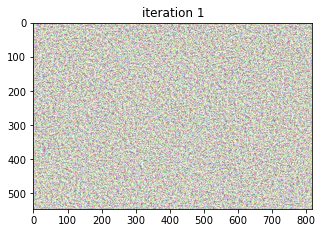

iteration      500, loss 2538984.75, content loss 130554.30, style loss 2460652.25
iteration     1000, loss 2329981.25, content loss 167793.80, style loss 2229304.75
iteration     1500, loss 2708801.25, content loss 141919.25, style loss 2623650.00
iteration     2000, loss 2141711.75, content loss 146083.22, style loss 2054061.75


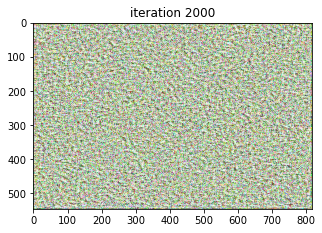

iteration     2500, loss 1751885.50, content loss 123494.05, style loss 1677789.12
iteration     3000, loss 1673340.12, content loss 116741.76, style loss 1603295.00
iteration     3500, loss 1428341.50, content loss 109395.14, style loss 1362704.38
iteration     4000, loss 1200567.88, content loss 102814.71, style loss 1138879.00


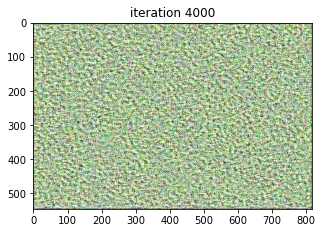

iteration     4500, loss 1000787.75, content loss 94605.64, style loss 944024.38
iteration     5000, loss 846975.19, content loss 87404.73, style loss 794532.38
iteration     5500, loss 719281.12, content loss 81401.37, style loss 670440.31
iteration     6000, loss 610121.94, content loss 76104.64, style loss 564459.19


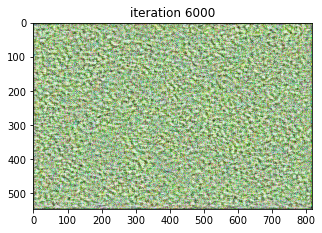

iteration     6500, loss 522396.97, content loss 71530.33, style loss 479478.78
iteration     7000, loss 451165.88, content loss 67385.17, style loss 410734.75
iteration     7500, loss 392441.19, content loss 63513.27, style loss 354333.25
iteration     8000, loss 343160.62, content loss 59904.55, style loss 307217.84


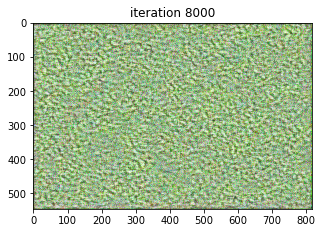

iteration     8500, loss 301203.06, content loss 56557.45, style loss 267268.59
iteration     9000, loss 264983.12, content loss 53455.29, style loss 232909.97
iteration     9500, loss 234111.19, content loss 50625.53, style loss 203735.86
iteration    10000, loss 207752.19, content loss 47984.55, style loss 178961.45


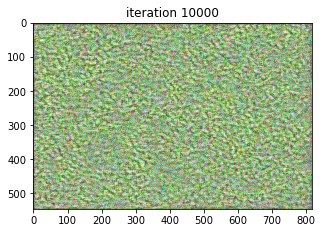

iteration    10500, loss 184784.78, content loss 45490.58, style loss 157490.44
iteration    11000, loss 164655.94, content loss 43200.62, style loss 138735.56
iteration    11500, loss 146712.78, content loss 41061.07, style loss 122076.15
iteration    12000, loss 130780.48, content loss 39070.98, style loss 107337.89


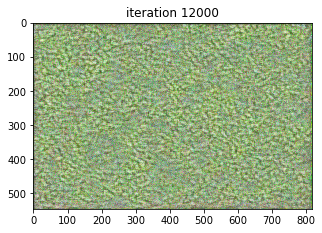

iteration    12500, loss 116775.99, content loss 37203.11, style loss 94454.12
iteration    13000, loss 104360.75, content loss 35405.10, style loss 83117.69
iteration    13500, loss 93476.92, content loss 33726.71, style loss 73240.90
iteration    14000, loss 83917.39, content loss 32171.87, style loss 64614.27


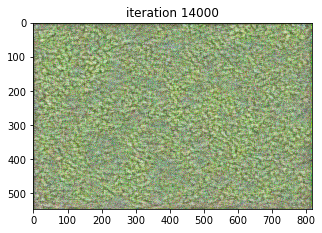

iteration    14500, loss 75505.92, content loss 30734.02, style loss 57065.51
iteration    15000, loss 68039.78, content loss 29378.67, style loss 50412.58
iteration    15500, loss 61356.76, content loss 28078.51, style loss 44509.65
iteration    16000, loss 55413.55, content loss 26849.53, style loss 39303.82


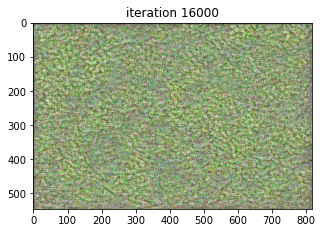

iteration    16500, loss 50158.96, content loss 25687.13, style loss 34746.68
iteration    17000, loss 45521.94, content loss 24573.37, style loss 30777.92
iteration    17500, loss 41432.11, content loss 23517.77, style loss 27321.44
iteration    18000, loss 37813.63, content loss 22503.35, style loss 24311.62


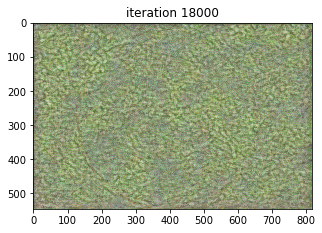

iteration    18500, loss 34627.27, content loss 21540.96, style loss 21702.70
iteration    19000, loss 31795.50, content loss 20616.12, style loss 19425.83
iteration    19500, loss 29269.21, content loss 19728.43, style loss 17432.15
iteration    20000, loss 26998.71, content loss 18873.66, style loss 15674.51


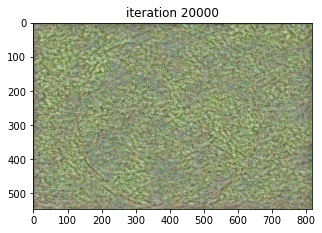

iteration    20500, loss 24950.52, content loss 18046.87, style loss 14122.40
iteration    21000, loss 23104.09, content loss 17247.73, style loss 12755.45
iteration    21500, loss 21437.88, content loss 16477.35, style loss 11551.47
iteration    22000, loss 19936.12, content loss 15741.26, style loss 10491.36


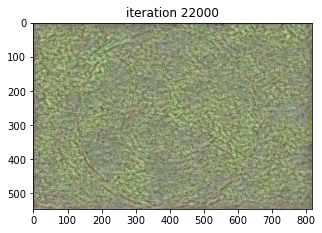

iteration    22500, loss 18576.60, content loss 15040.26, style loss 9552.44
iteration    23000, loss 17347.58, content loss 14375.58, style loss 8722.23
iteration    23500, loss 16236.30, content loss 13748.63, style loss 7987.12
iteration    24000, loss 15229.31, content loss 13162.48, style loss 7331.82


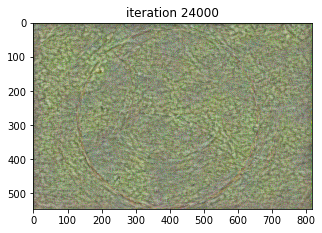

iteration    24500, loss 14316.51, content loss 12618.45, style loss 6745.44
iteration    25000, loss 13488.31, content loss 12112.08, style loss 6221.06
iteration    25500, loss 12731.32, content loss 11636.87, style loss 5749.20
iteration    26000, loss 12035.69, content loss 11190.15, style loss 5321.60


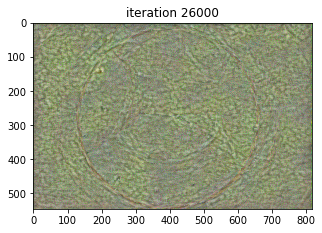

iteration    26500, loss 11396.56, content loss 10770.06, style loss 4934.52
iteration    27000, loss 10806.38, content loss 10374.17, style loss 4581.88
iteration    27500, loss 10261.95, content loss 9999.94, style loss 4261.99
iteration    28000, loss 9760.30, content loss 9647.23, style loss 3971.96


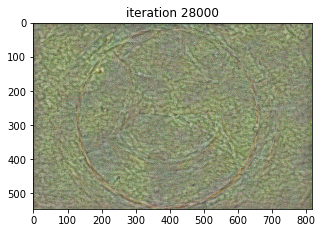

iteration    28500, loss 9297.75, content loss 9315.85, style loss 3708.24
iteration    29000, loss 8872.58, content loss 9004.96, style loss 3469.60
iteration    29500, loss 8482.32, content loss 8714.44, style loss 3253.66
iteration    30000, loss 8123.36, content loss 8440.80, style loss 3058.89


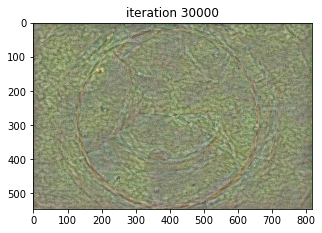

iteration    30500, loss 7790.82, content loss 8180.95, style loss 2882.25
iteration    31000, loss 7481.57, content loss 7933.10, style loss 2721.71
iteration    31500, loss 7193.00, content loss 7695.54, style loss 2575.68
iteration    32000, loss 6924.18, content loss 7469.20, style loss 2442.66


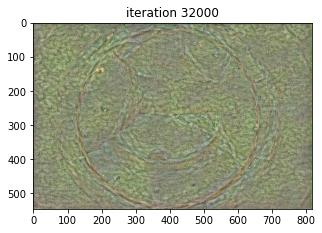

iteration    32500, loss 6674.23, content loss 7253.94, style loss 2321.87
iteration    33000, loss 6442.68, content loss 7050.59, style loss 2212.33
iteration    33500, loss 6227.23, content loss 6858.33, style loss 2112.23
iteration    34000, loss 6026.72, content loss 6676.26, style loss 2020.96


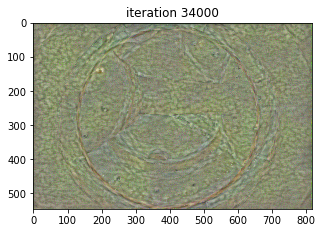

iteration    34500, loss 5839.58, content loss 6503.41, style loss 1937.54
iteration    35000, loss 5664.59, content loss 6338.24, style loss 1861.64
iteration    35500, loss 5501.29, content loss 6181.01, style loss 1792.68
iteration    36000, loss 5349.21, content loss 6031.53, style loss 1730.29


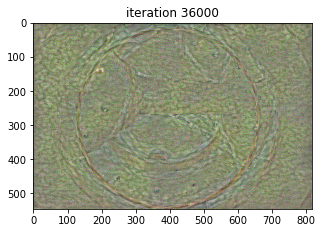

iteration    36500, loss 5207.05, content loss 5890.12, style loss 1672.98
iteration    37000, loss 5073.58, content loss 5755.89, style loss 1620.04
iteration    37500, loss 4948.08, content loss 5627.68, style loss 1571.48
iteration    38000, loss 4829.85, content loss 5504.69, style loss 1527.04


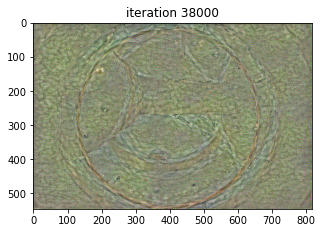

iteration    38500, loss 4718.41, content loss 5386.26, style loss 1486.65
iteration    39000, loss 4613.34, content loss 5271.93, style loss 1450.19
iteration    39500, loss 4514.53, content loss 5161.86, style loss 1417.41
iteration    40000, loss 4421.73, content loss 5055.95, style loss 1388.16


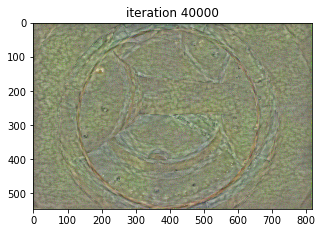

iteration    40500, loss 4334.22, content loss 4954.47, style loss 1361.54
iteration    41000, loss 4250.96, content loss 4857.15, style loss 1336.67
iteration    41500, loss 4172.10, content loss 4765.11, style loss 1313.04
iteration    42000, loss 4097.64, content loss 4678.20, style loss 1290.71


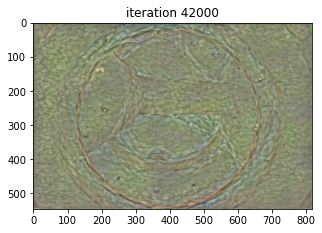

iteration    42500, loss 4027.01, content loss 4596.02, style loss 1269.39
iteration    43000, loss 3959.91, content loss 4518.11, style loss 1249.04
iteration    43500, loss 3896.30, content loss 4443.95, style loss 1229.93
iteration    44000, loss 3835.90, content loss 4372.62, style loss 1212.32


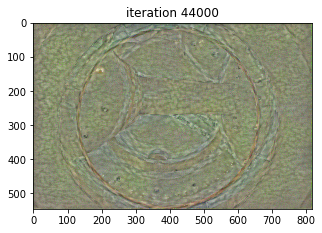

iteration    44500, loss 3778.32, content loss 4303.33, style loss 1196.32
iteration    45000, loss 3723.61, content loss 4236.41, style loss 1181.76
iteration    45500, loss 3671.74, content loss 4172.30, style loss 1168.36
iteration    46000, loss 3622.29, content loss 4110.70, style loss 1155.87


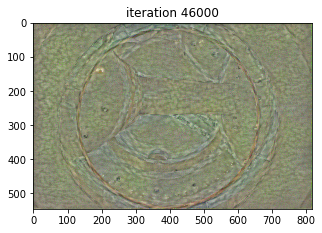

iteration    46500, loss 3574.90, content loss 4051.42, style loss 1144.05
iteration    47000, loss 3529.63, content loss 3994.53, style loss 1132.91
iteration    47500, loss 3486.51, content loss 3940.22, style loss 1122.37
iteration    48000, loss 3445.28, content loss 3888.27, style loss 1112.32


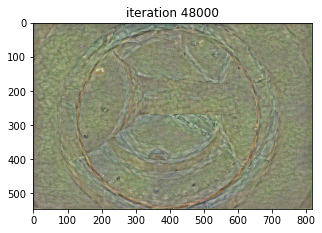

iteration    48500, loss 3405.81, content loss 3838.07, style loss 1102.97
iteration    49000, loss 3367.93, content loss 3789.38, style loss 1094.31
iteration    49500, loss 3331.58, content loss 3741.88, style loss 1086.45
iteration    50000, loss 3296.81, content loss 3696.13, style loss 1079.13


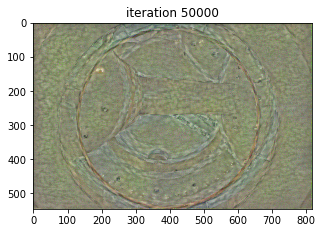

iteration    50500, loss 3263.43, content loss 3652.07, style loss 1072.19
iteration    51000, loss 3231.34, content loss 3609.63, style loss 1065.56
iteration    51500, loss 3200.39, content loss 3568.69, style loss 1059.17
iteration    52000, loss 3170.59, content loss 3529.20, style loss 1053.07


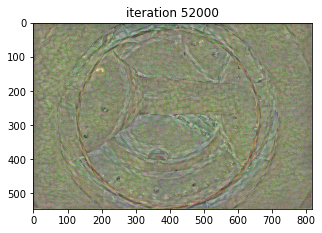

iteration    52500, loss 3141.83, content loss 3490.98, style loss 1047.25
iteration    53000, loss 3114.18, content loss 3454.16, style loss 1041.68
iteration    53500, loss 3087.60, content loss 3418.66, style loss 1036.40
iteration    54000, loss 3061.92, content loss 3384.36, style loss 1031.31


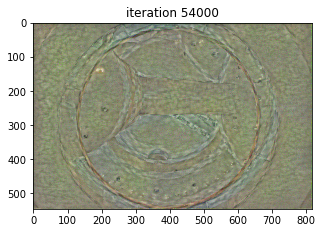

iteration    54500, loss 3037.02, content loss 3351.27, style loss 1026.26
iteration    55000, loss 3012.98, content loss 3319.35, style loss 1021.37
iteration    55500, loss 2989.82, content loss 3288.49, style loss 1016.72
iteration    56000, loss 2967.39, content loss 3258.49, style loss 1012.30


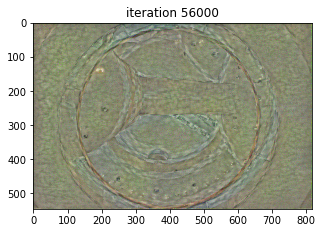

iteration    56500, loss 2945.60, content loss 3229.19, style loss 1008.08
iteration    57000, loss 2924.54, content loss 3200.32, style loss 1004.35
iteration    57500, loss 2904.22, content loss 3172.03, style loss 1001.00
iteration    58000, loss 2884.56, content loss 3144.70, style loss 997.74


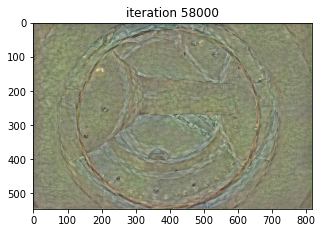

iteration    58500, loss 2865.55, content loss 3118.45, style loss 994.48
iteration    59000, loss 2847.11, content loss 3093.34, style loss 991.11
iteration    59500, loss 2829.21, content loss 3068.99, style loss 987.81
iteration    60000, loss 2811.90, content loss 3045.32, style loss 984.71


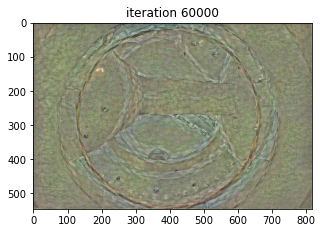

iteration    60500, loss 2795.16, content loss 3022.22, style loss 981.83
iteration    61000, loss 2778.90, content loss 2999.68, style loss 979.09
iteration    61500, loss 2763.11, content loss 2977.65, style loss 976.53
iteration    62000, loss 2747.81, content loss 2956.31, style loss 974.03


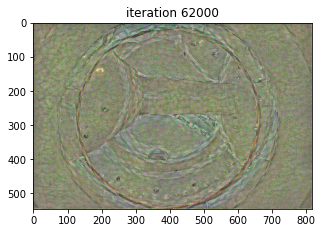

iteration    62500, loss 2732.93, content loss 2935.66, style loss 971.53
iteration    63000, loss 2718.46, content loss 2915.54, style loss 969.14
iteration    63500, loss 2704.38, content loss 2895.89, style loss 966.85
iteration    64000, loss 2690.69, content loss 2876.66, style loss 964.69


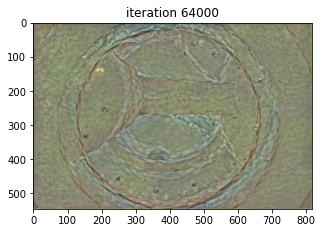

iteration    64500, loss 2677.34, content loss 2857.85, style loss 962.63
iteration    65000, loss 2664.32, content loss 2839.44, style loss 960.66
iteration    65500, loss 2651.60, content loss 2821.35, style loss 958.79
iteration    66000, loss 2639.21, content loss 2803.83, style loss 956.91


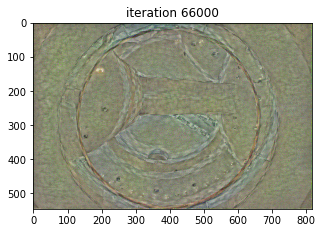

iteration    66500, loss 2627.14, content loss 2786.78, style loss 955.07
iteration    67000, loss 2615.33, content loss 2770.27, style loss 953.16
iteration    67500, loss 2603.81, content loss 2754.27, style loss 951.25
iteration    68000, loss 2592.55, content loss 2738.76, style loss 949.29


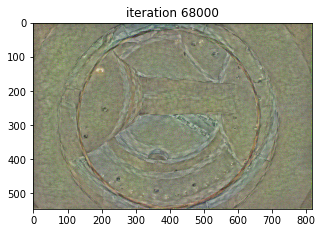

iteration    68500, loss 2581.51, content loss 2723.50, style loss 947.41
iteration    69000, loss 2570.73, content loss 2708.39, style loss 945.69
iteration    69500, loss 2560.16, content loss 2693.37, style loss 944.14
iteration    70000, loss 2549.82, content loss 2678.54, style loss 942.69


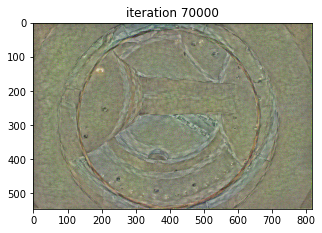

iteration    70500, loss 2539.71, content loss 2664.13, style loss 941.23
iteration    71000, loss 2529.81, content loss 2650.15, style loss 939.72
iteration    71500, loss 2520.15, content loss 2636.72, style loss 938.12
iteration    72000, loss 2510.69, content loss 2623.78, style loss 936.43


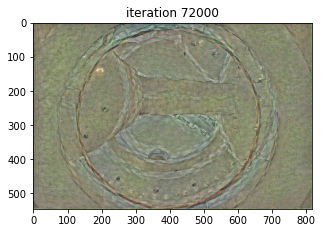

iteration    72500, loss 2501.42, content loss 2611.09, style loss 934.77
iteration    73000, loss 2492.33, content loss 2598.46, style loss 933.25
iteration    73500, loss 2483.41, content loss 2585.95, style loss 931.84
iteration    74000, loss 2474.68, content loss 2573.79, style loss 930.41


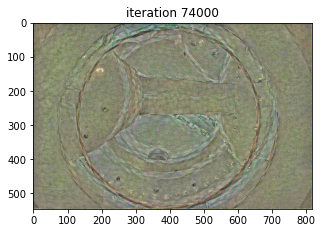

iteration    74500, loss 2466.12, content loss 2561.95, style loss 928.95
iteration    75000, loss 2457.74, content loss 2550.44, style loss 927.48
iteration    75500, loss 2449.52, content loss 2539.05, style loss 926.09
iteration    76000, loss 2441.45, content loss 2527.68, style loss 924.84


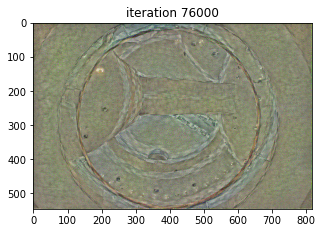

iteration    76500, loss 2433.52, content loss 2516.49, style loss 923.63
iteration    77000, loss 2425.73, content loss 2505.58, style loss 922.38
iteration    77500, loss 2418.10, content loss 2494.92, style loss 921.15
iteration    78000, loss 2410.63, content loss 2484.54, style loss 919.90


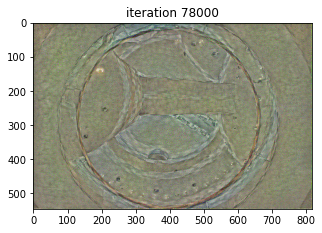

iteration    78500, loss 2403.25, content loss 2474.42, style loss 918.60
iteration    79000, loss 2396.04, content loss 2464.43, style loss 917.39
iteration    79500, loss 2388.96, content loss 2454.36, style loss 916.34
iteration    80000, loss 2381.99, content loss 2444.37, style loss 915.37


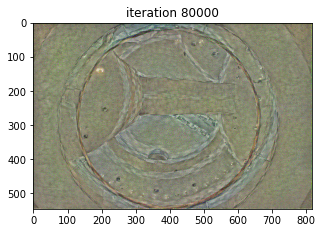

iteration    80500, loss 2375.15, content loss 2434.78, style loss 914.28
iteration    81000, loss 2368.40, content loss 2425.54, style loss 913.08
iteration    81500, loss 2361.77, content loss 2416.42, style loss 911.91
iteration    82000, loss 2355.25, content loss 2407.27, style loss 910.89


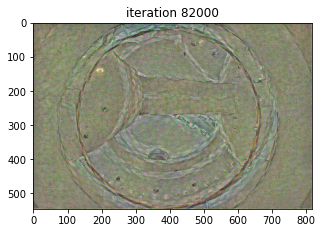

iteration    82500, loss 2348.82, content loss 2398.13, style loss 909.94
iteration    83000, loss 2342.53, content loss 2389.32, style loss 908.93
iteration    83500, loss 2336.31, content loss 2380.78, style loss 907.84
iteration    84000, loss 2330.20, content loss 2372.34, style loss 906.80


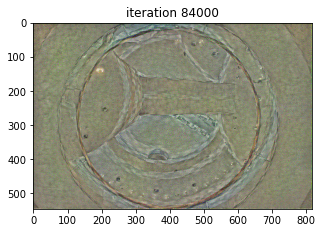

iteration    84500, loss 2324.21, content loss 2364.03, style loss 905.79
iteration    85000, loss 2318.31, content loss 2355.82, style loss 904.82
iteration    85500, loss 2312.50, content loss 2347.69, style loss 903.88
iteration    86000, loss 2306.77, content loss 2339.62, style loss 902.99


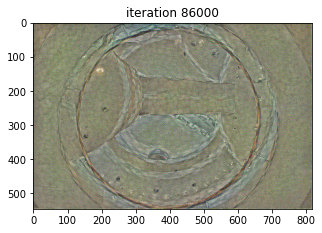

iteration    86500, loss 2301.13, content loss 2331.67, style loss 902.13
iteration    87000, loss 2295.56, content loss 2323.76, style loss 901.30
iteration    87500, loss 2290.08, content loss 2316.02, style loss 900.46
iteration    88000, loss 2284.68, content loss 2308.54, style loss 899.56


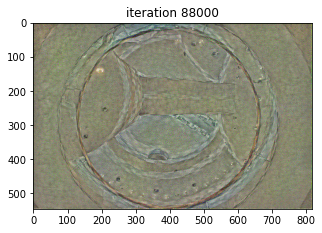

iteration    88500, loss 2279.35, content loss 2301.10, style loss 898.69
iteration    89000, loss 2274.09, content loss 2293.67, style loss 897.89
iteration    89500, loss 2268.92, content loss 2286.36, style loss 897.10
iteration    90000, loss 2263.82, content loss 2279.19, style loss 896.31


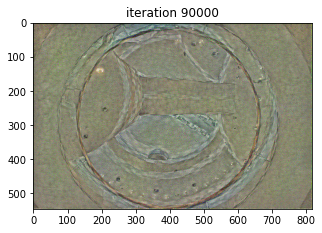

iteration    90500, loss 2258.80, content loss 2272.05, style loss 895.58
iteration    91000, loss 2253.87, content loss 2265.08, style loss 894.83
iteration    91500, loss 2249.01, content loss 2258.20, style loss 894.09
iteration    92000, loss 2244.24, content loss 2251.45, style loss 893.37


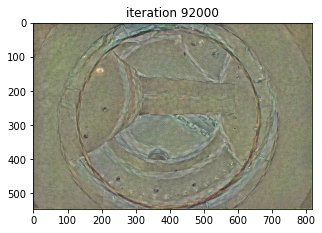

iteration    92500, loss 2239.53, content loss 2244.79, style loss 892.66
iteration    93000, loss 2234.89, content loss 2238.33, style loss 891.90
iteration    93500, loss 2230.32, content loss 2232.06, style loss 891.09
iteration    94000, loss 2225.82, content loss 2225.93, style loss 890.26


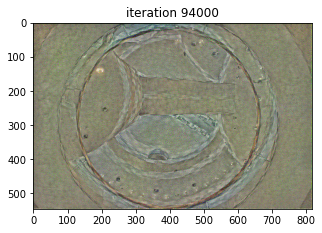

iteration    94500, loss 2221.37, content loss 2219.76, style loss 889.51
iteration    95000, loss 2217.00, content loss 2213.68, style loss 888.78
iteration    95500, loss 2212.67, content loss 2207.65, style loss 888.08
iteration    96000, loss 2208.42, content loss 2201.70, style loss 887.40


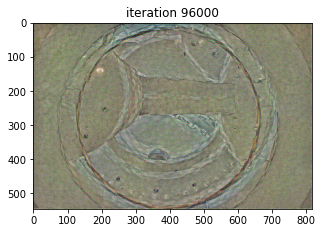

iteration    96500, loss 2204.23, content loss 2195.83, style loss 886.73
iteration    97000, loss 2200.09, content loss 2190.19, style loss 885.97
iteration    97500, loss 2196.01, content loss 2184.72, style loss 885.18
iteration    98000, loss 2191.99, content loss 2179.16, style loss 884.49


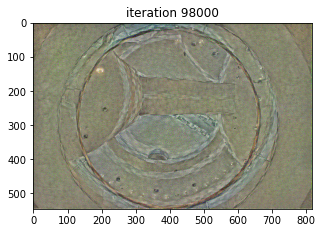

iteration    98500, loss 2188.01, content loss 2173.55, style loss 883.88
iteration    99000, loss 2184.10, content loss 2168.01, style loss 883.29


In [ ]:
training_loop(content_img_tensor, style_img_tensor, gen_tensor, 
              content_layers, style_layers, img_size, optimizer, 
              content_w, style_w, training_iterations)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(21, 7))
axs[0].imshow(deprocess_image(content_img_tensor))
axs[0].set_title("Content")
axs[0].axis('off')
axs[1].imshow(deprocess_image(style_img_tensor))
axs[1].set_title("Style")
axs[1].axis('off')
axs[2].imshow(deprocess_image(gen_tensor))
axs[2].set_title("Combination")
plt.axis('off')
plt.savefig("./nst.jpg", dpi=150)
plt.show()

##### 